# LCPB 22-23 Exercise 1 (Gradient descent & Deep Neural Networks, DNNs) 


<center><h1>Group 2307</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Matricola number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |1219907 (tri)   |
| Cacciola           | Martina               |2097476         |
| Pervysheva         | Yelyzaveta            |2039398         |           
| Waththe Liyanage   | Wageesha Widuranga    |2078719         |




# Table of Contents:
* [Overview](#overview)
    - [Implementation Details](#implementation)
* [Import Packages and Modules](#importing)
* [Load Dataset](#load)
* [Plot Dataset](#plot)
* [Define size of the training set](#define)
* [Spliting Training and Validation data](#split)
* [Rescaling](#rescale)
* [Following cases](#cases)
* [Model creation](#model_creation)
    - [Best Optimizer](#opt)
    - [Best Batch Size](#batch)
    - [Best Dropout Value](#dropout)
    - [Best Activation Function](#func)
* [Model with best Parameters](#model_best)
    - [Confusion Matrix](#confusion)
* [Reduced Data](#reduced)
* [Increased Data](#increased)
* [Augmented Data](#aug)
* [Task 3 (butterfly)](#butterfly)
* [Task 3 (Jupiter)](#jupiter)

# Overview <a class="anchor" id="overview"></a>

In this assignment, we will analyze labeled 2D data x=(x1,x2) introduced in the second lesson using Deep Neural Networks (DNNs) and gradient descent. The main goals of the assignment are:

1. Implement a "grid search" to improve at least two aspects or hyperparameters of the model.
2. Take the best DNN from point 1 and study how its performance changes when the number N of samples is a) reduced, b) increased, or c) augmented.
3. Optionally, we will explore what happens with data generated by the second nonlinear function or other choices.

## Implementation Details <a class="anchor" id="implementation"></a>

### Grid Search
To improve the DNN model, we will implement a "grid search" technique, as shown in the Mehta et al. notebook NB11, where we will explore different hyperparameters of the model. We will focus on at least two aspects, such as the choice of the minimization algorithm (ADAM, RMSprop, Nesterov, etc.), activation units (sigmoid, ReLU, ELU, etc.), dropout values, learning rate, size or number of layers, and rescaling of data.

### Performance Analysis
After improving the DNN model, we will analyze how its performance changes with different sample sizes, including reduced, increased, and augmented datasets. For the augmented dataset, we will generate artificial training samples similar to the real ones, where each sample x=($x_1$, $x_2$) is transformed to multiple copies ($x_1+s_1$, $x_2+s_2$), where each ($s_1$, $s_2$) is a reasonably slight random shift. We will also explain our choice for the variability of this shift and why we do not augment the validation samples.

### Optional Exploration
Optionally, we will explore what happens with data generated by the second nonlinear function or other choices.


# Import packages and modules <a class="anchor" id="importing"></a>

In [1]:
from __future__ import print_function
import keras, sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=0
np.random.seed(seed)

In [2]:
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
from keras.optimizers import adam_v2, rmsprop_v2, nadam_v2, adamax_v2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier

# Load Dataset  <a class="anchor" id="load"></a>

The dataset is generated by randomly generating 4000 data points with coordinates following a uniform distribution in the range of -50 to +50. The points are labeled with a value of `1` if they satisfy all three boundary conditions, `0` otherwise.

In [3]:
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

# Plot Dataset <a class="anchor" id="plot"></a>

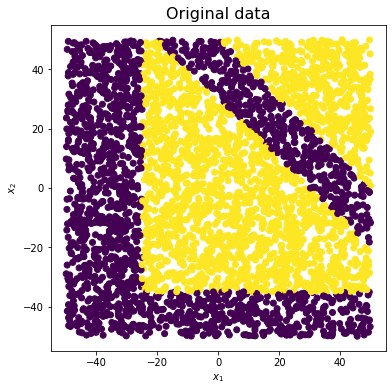

In [4]:
plt.figure(figsize = (6, 6))
plt.scatter(x[:,0], x[:,1], c=y, marker='o')
plt.title('Original data', fontsize=16)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

# Define size of the training set <a class="anchor" id="def"></a>

In this code we define the proportion of the original dataset to be used as training data using the variable `Per_train` (here set to 0.8, i.e., 80% of the data), and we calculate the number of samples in the original dataset using N and the number of features (dimensionality) of each sample using L.

In [5]:
Per_train = 0.8

N = len(x)
L = len(x[0])
N_train = int(Per_train*N)

print("Number of samples in the dataset:", N)
print("Number of samples in the train data:", N_train)

Number of samples in the dataset: 4000
Number of samples in the train data: 3200


# Spliting Training and Validation data <a class="anchor" id="split"></a>

We split the data betweet training and validation set, based on the `Per_train` value.  
We shuffle the two new dataset in anticipation of forming mini-batches. This is an important step in order to prevent that the gradient method can fit spurious correlations resulting from the order in which data is presented.

In [7]:
(x_train1, y_train1) = (x[0:N_train], y[0:N_train])
(x_valid1, y_valid1) = (x[N_train:], y[N_train:])

print("Train samples:",len(x_train1),"\t Validation samples:",len(x_valid1))

Train samples: 3200 	 Validation samples: 800


# Rescaling <a class="anchor" id="rescale"></a>

It has been found that if the original values of data differ by order of magnitude, training can be slowed down or impeded. This can be traced back to the _vanishing and exploding gradient problem_.  

To avoid this all data should be mean-centered (i.e. `x-x.mean()`) and should be rescaled. In our case the data are normally distributed so we rescale them by the standard deviation (`x.std()`). Rescaling ensures that the weights of the DNN are of a similar order of magnitude.  

This two passages are included in the function `Rescaling(x)`. We apply it to the training x=($x_1$, $x_2$) values. 
The labels don't need to be "adjusted" because they are simply 0 or 1.

In [8]:
def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train = Rescaling(x_train1)
x_valid = Rescaling(x_valid1)

print("Training samples:", len(x_train))

Training samples: 3200


# Following cases <a class="anchor" id="cases"></a>

The steps desribed above will be repeated for all the following cases:

- Original dataset
- Reduced dataset
- Increased datatset
- Augmented dataset
- task 3 (butterfly)
- Task 3 (Jupiter)

# Model Creation <a class="anchor" id="model_creation"></a>

Here we create the NN model, looking for the best parameters. We focused on:

1. _optimizer_: the optimization algorithm used to train the model, with a default value of Adam optimizer.
2. _activation_: the activation function used for the hidden layers of the network, with a default value of ReLU.
3. _dropout_rate_: the rate at which randomly dropout connections between neurons during training, with a default value of 0.2.

The model consists of an input layer, two hidden layers with 20 neurons each and the specified activation function, a dropout layer to prevent overfitting and an output layer with a sigmoid activation function for binary classification.

The model is compiled using binary cross-entropy loss and accuracy as the evaluation metric. Finally, the model is returned.

In [9]:
def created_model(optimizer= adam_v2.Adam(), activation='relu', dropout_rate=0.2):
    
    model = Sequential() 
    model.add(Dense(L, input_shape=(L,), activation=activation))
    model.add(Dense(20, activation=activation))  
    model.add(Dense(20, activation=activation))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

## Best Optimizer <a class="anchor" id="opt"></a>

Here we use _grid search cross-validation_ to find the best optimizer algorithm to use for our NN model. 
We create a `KerasClassifier` object with the `created_model` function we defined earlier, and set the number of epochs to 60 and the batch size to 64. We then define a parameter grid to search over, which includes different optimizer algorithms.


In summary, we use grid search cross-validation to find the best optimizer algorithm to use for our NN model, and store the best optimizer found.

The best optimizer is printed with its mean test score and the std deviation between (). The optimizer tested can be found in the `optimizer` list below.

In [11]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import

import tensorflow as tf
tf.autograph.set_verbosity(0)

batch_size = 64

model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=60, 
                        batch_size=batch_size, 
                        verbose=False)

optimizer = ['SGD', 'RMSprop', 'Adagrad','Adam', 'Adamax', 'Nadam']

# define parameter dictionary
param_grid = dict(optimizer=optimizer)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train1)

# summarize results
# print the best optimizer
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the name of the optimizer
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best optimizer    
best_optimizer = grid_result.best_params_['optimizer']

Best: 0.877187 using {'optimizer': 'Nadam'}

0.781875 (0.044428) with: {'optimizer': 'SGD'}
0.855625 (0.002864) with: {'optimizer': 'RMSprop'}
0.667812 (0.053636) with: {'optimizer': 'Adagrad'}
0.866875 (0.018297) with: {'optimizer': 'Adam'}
0.781562 (0.039045) with: {'optimizer': 'Adamax'}
0.877187 (0.022315) with: {'optimizer': 'Nadam'}


## Best Batch Size <a class="anchor" id="batch"></a>

Here, we are tuning the hyperparameter _batch size_ for the NN model. We create a `KerasClassifier` object with the `created_model` function, and set the number of epochs and verbose parameters. 
We then define a range of batch sizes to test and create a grid search object using `GridSearchCV` from `scikit-learn`. 
We fit the grid search object to our training data and print out the best mean test score and corresponding hyperparameters. We also print out the mean test score, standard deviation, and hyperparameters for each batch size tested. 
Finally, we extract the best batch size found by the grid search.

<!--- The result shows that the best mean test score of 0.802187 was achieved with a batch size of 64. The other batch sizes tested, in descending order of mean test score, were 32 and 128. The standard deviation of the test scores is also provided for each batch size. -->

Batch size is an important hyperparameter in NN training. A larger batch size may result in a faster convergence and better optimization, but may also require more memory and slower training time. In contrast, a smaller batch size may require less memory and have faster training time, but may result in a slower convergence and suboptimal optimization.

<!--- The best batch size depends on the epochs value. if it's 50, the best batch is 64. if it's 60, the best is 32`  
`# I think the best way is to be consistent w/ the epochs value of the very first NN, aka epochs=60` -->

In [12]:
model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


batch_size = [32, 64, 128]


param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train1)

# summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the size of the batch
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best batch    
best_batch_size = grid_result.best_params_['batch_size']

Best: 0.875625 using {'batch_size': 32}

0.875625 (0.012824) with: {'batch_size': 32}
0.866250 (0.012562) with: {'batch_size': 64}
0.844688 (0.054668) with: {'batch_size': 128}


## Best Droupout Value <a class="anchor" id="dropout"></a>

The best _dropout rate_ is then selected based on the mean test score.

The model is created with the previously optimized batch size, and an epoch of 50. The dropout rate is set to a list of four values: 0.1, 0.2, 0.3, and 0.4. We use GridSearchCV to perform a 4-fold cross-validation on each of the dropout rates in the list, and the best dropout rate is returned.

<!--- `# I think we should use epochs=60` -->

The results show the mean test score and standard deviation of the test scores for each dropout rate. The best dropout rate found by the grid search is printed along with its corresponding mean test score.

In [13]:
batch_size = best_batch_size

model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


dropout_rate = [0.1, 0.2, 0.3, 0.4]

param_grid = dict(dropout_rate=dropout_rate)


grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the dropout rate
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# store the best dropout rate
best_dropout_rate = grid_result.best_params_['dropout_rate']

Best: 0.869375 using {'dropout_rate': 0.4}
0.865625 (0.017995) with: {'dropout_rate': 0.1}
0.845000 (0.033854) with: {'dropout_rate': 0.2}
0.839062 (0.042988) with: {'dropout_rate': 0.3}
0.869375 (0.007930) with: {'dropout_rate': 0.4}


## Best Activation Function <a class="anchor" id="func"></a>

_Activation functions_ are mathematical equations that determine the output of a neural network model. Different activation functions have different effects on the performance and convergence of the model.

The results shown indicate that `ReLU` is the best activation function for our model, as it has the highest mean accuracy and a relatively low standard deviation. This means that `ReLU` is able to produce consistent and accurate outputs for our data.

Some possible reasons why `ReLU` is better than other activation functions are:

- ReLU is simple and computationally efficient.
- ReLU avoids the _vanishing gradient problem_ that affects sigmoid and tanh.
- ReLU can handle sparse data better than linear or softmax.

In [14]:
batch_size = 64
model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']

param_grid = dict(activation=activation)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=2, cv=4)
grid_result = grid.fit(x_train, y_train1)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the name of the activation function
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best activation function
best_activation = grid_result.best_params_['activation']

Best: 0.867812 using {'activation': 'relu'}
0.761562 (0.008987) with: {'activation': 'softmax'}
0.805312 (0.052421) with: {'activation': 'softsign'}
0.867812 (0.024691) with: {'activation': 'relu'}
0.813750 (0.034944) with: {'activation': 'tanh'}
0.740938 (0.003233) with: {'activation': 'sigmoid'}
0.674063 (0.019633) with: {'activation': 'linear'}


# Model with best Parameters <a class="anchor" id="model_best"></a>

Our best model has the following structure:

- An input layer with L nodes, where L is the dimension of our input data. This layer uses an activation function that we have chosen as the best one for our problem (`best_activation`).
- Two hidden layers with 20 nodes each, using the same activation function as the input layer (`best_activation`).
- A dropout layer with a dropout rate that we have chosen as the best one for our problem (`best_dropout_rate`). This layer randomly drops out some nodes during training to prevent overfitting.
- An output layer with one node, using a `sigmoid` activation function. This layer produces a binary output (0 or 1) for our classification problem.
- A loss function of `binary crossentropy`, which measures how well the model predicts the true labels of our data.
- An optimizer that we have chosen as the best one for our problem (`best_optimizer`), which updates the weights of our model based on the gradients of the loss function.
- A metric of `accuracy`, which measures how many predictions our model gets right on the data.

We now train our best NN model on `x_train` and `y_train` data for 450 epochs, using a batch size that we have chosen as the best one for your problem (`best_batch_size`). We have also validate our model on `x_valid` and `y_valid` data during training to monitor its performance.

This model will be used in all the four cases, changing only the training and validation samples, according to the case (original dataset, reduced dataset, ...)

In [15]:
# Creating and training the NN model w/ our best parameters
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size


# Fitting again with more data
fit = best_model.fit(x_train, y_train1, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid1), verbose=False)

The best validation accuracy is 0.894


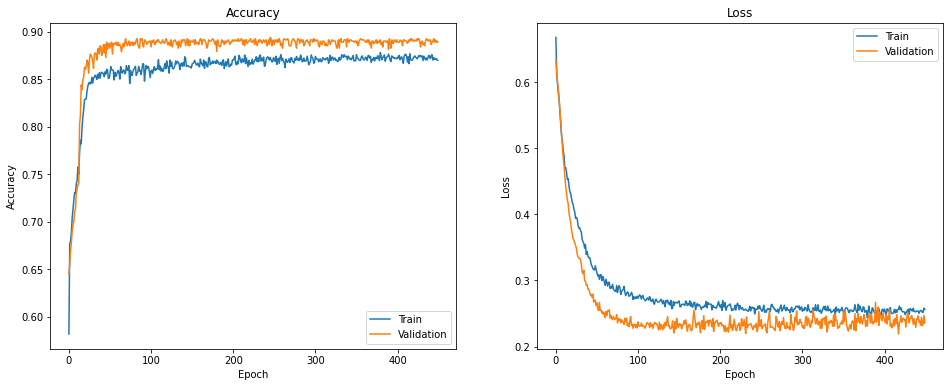

In [16]:
# Printing the max validation accuracy value
max_val_acc = np.max(fit.history['val_accuracy'])
print('The best validation accuracy is %.3f' %(max_val_acc))

# Creating the plot
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit.history['accuracy'])
ax1.plot(fit.history['val_accuracy'])

# Setting labels and legend
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit.history['loss'])
ax2.plot(fit.history['val_loss'])

# Setting labels and legend
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The best validation accuracy, 0.894, was achieved on the 245th epoch.


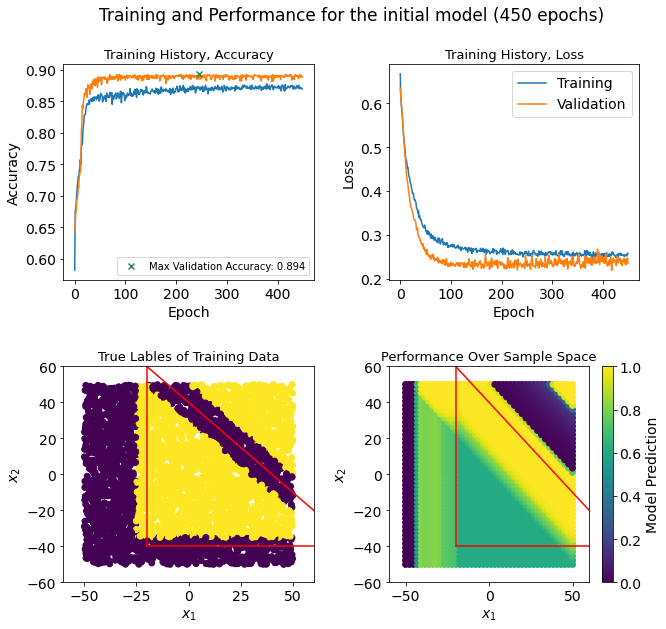

In [17]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:]  =(x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)

# Best validation accuracy
plt.rcParams['font.size'] = 14
max_val_acc = np.max(fit.history['val_accuracy'])
max_val_epoch = np.argmax(fit.history['val_accuracy'])
print('The best validation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc, max_val_epoch))

# perfomance vs epochs plot
fig, AX = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle('Training and Performance for the initial model (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc, 3))
ax.scatter(max_val_epoch, max_val_acc, color='seagreen', marker='x', label=mystring, zorder=10)
ax.plot(fit.history['accuracy'])
ax.plot(fit.history['val_accuracy'])
ax.legend(fontsize=10, loc='best')
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax = AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit.history['loss'], label="Training")
ax.plot(fit.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20, -20), (-40, 60), c="r")
    ax.plot((-20, 80), (-40, -40), c="r")
    ax.plot((-20, 80), (60, -40), c="r")

# True Lables of Training Data
ax = AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax = AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

The accuracy our NN model achieved means that, out of all the instances or observations in a dataset, the model is correctly predicting the outcome or class label.

## Confusion matrix <a class="anchor" id="confusion"></a>

The **confusion matrix** is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. It is extremely useful for measuring Accuracy, Precision, etc.

This is an example of a confusion matrix:
![This is an example of a confusion matrix.](./confusion_matrix.png)

- True Positive (TP): the model predicted label "positive (1)" and it's the correct one;
- True Negative (TN): the model predicted label "negative (0)" and it's the correct one;
- False Positive (FP): the model predicted label "positive (1)" and it's the not correct one;
- False Negative (FN): the model predicted label "negative (0)" and it's the not correct one;

In term of accuracy the confusion matrix tells us how many labels were predicted correctly (i.e. TP+TN).

It is intriguing to note that the model exhibits a high degree of accuracy while also making nearly an almost equal number of incorrect predictions for both of the two classes. This suggests that the model may be performing well in identifying patterns and features that are common to both classes, while struggling to differentiate between the subtle differences that distinguish them.

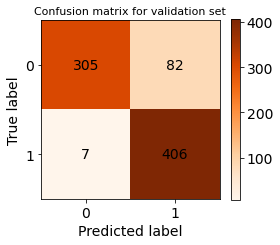

In [19]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid1, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=11)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Reduced Data <a class="anchor" id="reduced"></a>

This code  does the following:

- It loads previous files
- It randomly samples 50% of the rows from `x` and `y` using numpy’s `random.choice` function. This function takes an array of indices, a size of the sample and a boolean flag to indicate whether sampling is done with or without replacement. In this case, sampling is done without replacement, meaning that each row can only be selected once.
- It stores the sampled data and labels in `x_sampled` and `y_sampled` variables.

The reason for doing this is to reduce the size of the dataset for faster training or testing of the DNN model.

In [20]:
# Load the original dataset
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

# Randomly sample 50% of the rows
n_samples = int(0.5 * len(x))
indices = np.random.choice(len(x), size=n_samples, replace=False)
x_sampled = x[indices]
y_sampled = y[indices]

In [21]:
Per_train = 0.8

N = len(x_sampled)
L = len(x_sampled[0])
N_train = int(Per_train*N)

print("Number of samples in the reduced dataset:",N)
print("Number of samples in the reduced train dataset:",N_train)

# sampling between training and validation samples
(x_train_red, y_train_red) = (x_sampled[0:N_train], y_sampled[0:N_train])
(x_valid_red, y_valid_red) = (x_sampled[N_train:], y_sampled[N_train:])

Number of samples in the reduced dataset: 2000
Number of samples in the reduced train dataset: 1600


A smaller dataset was easier to load into memory and process, which  reduced the time spent on data preparation and increase the time spent on model training. This can lead to faster convergence of the model during training, as the model can quickly learn the patterns in the data.



In [22]:
# Rescaling the dataset

def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train_red = Rescaling(x_train_red)
x_valid_red = Rescaling(x_valid_red)

print("Number of samples in the reduced set:", len(x_train_red))

Number of samples in the reduced set: 1600


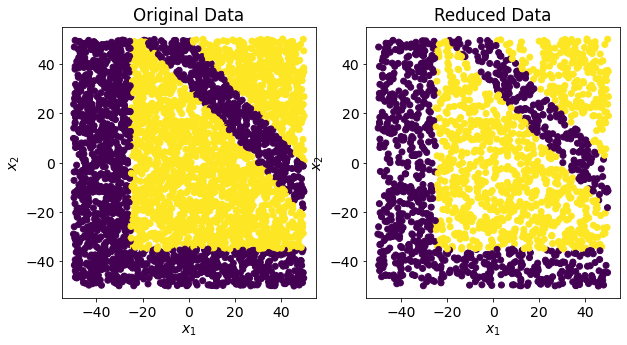

In [23]:
# Plot the original data and the reduced data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x_sampled[:, 0], x_sampled[:, 1], c=y_sampled)
axs[1].set_title('Reduced Data')

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')

plt.show()

In [24]:
# Creating and training our NN model w/ the reduced dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with reduced data
fit_red = best_model.fit(x_train_red, y_train_red, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_red, y_valid_red), verbose=False)

The best validation accuracy is 0.967.
The accuracy difference between original and reduced datasets is -0.074.


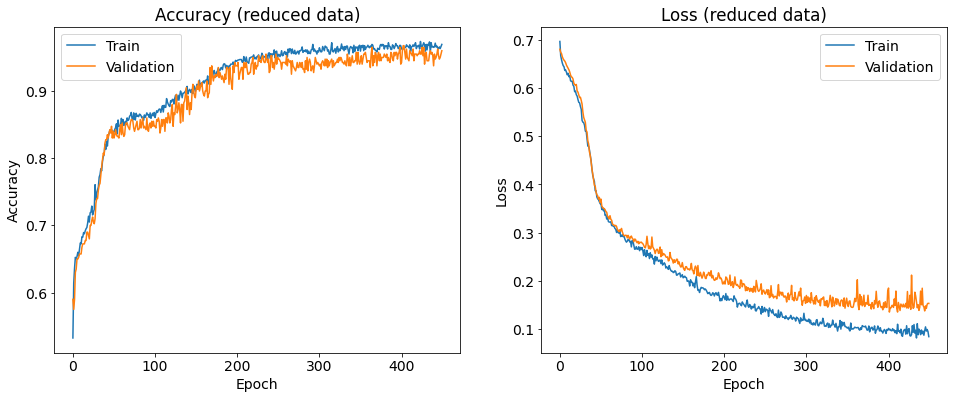

In [25]:
# Printing the max validation accurancy of the reduced dataset and
# the difference w/ the one of original dataset
max_val_acc_red = np.max(fit_red.history['val_accuracy'])
print('The best validation accuracy is %.3f.' %(max_val_acc_red))
print('The accuracy difference between original and reduced datasets is %.3f.' %((max_val_acc-max_val_acc_red)))

# Creating the plot
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_red.history['accuracy'])
ax1.plot(fit_red.history['val_accuracy'])

# Setting labels and legend
ax1.set_title('Accuracy (reduced data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_red.history['loss'])
ax2.plot(fit_red.history['val_loss'])

# Setting laels and legend
ax2.set_title('Loss (reduced data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

Even if we reduced half of the samples, the accuracy is slightly different from the one wrt the original dataset.

This means that the sampled data still contains enough information to train and test the DNN model with a relatively high accuracy. It also suggests that the original data may have some redundancy or noise that can be removed without affecting the model performance significantly. Reducing the number of samples can have some benefits such as saving memory and computation time, but it can also introduce some risks such as losing important features or introducing bias. 

The best validation accuracy, 0.967, was achieved on the 402th epoch.


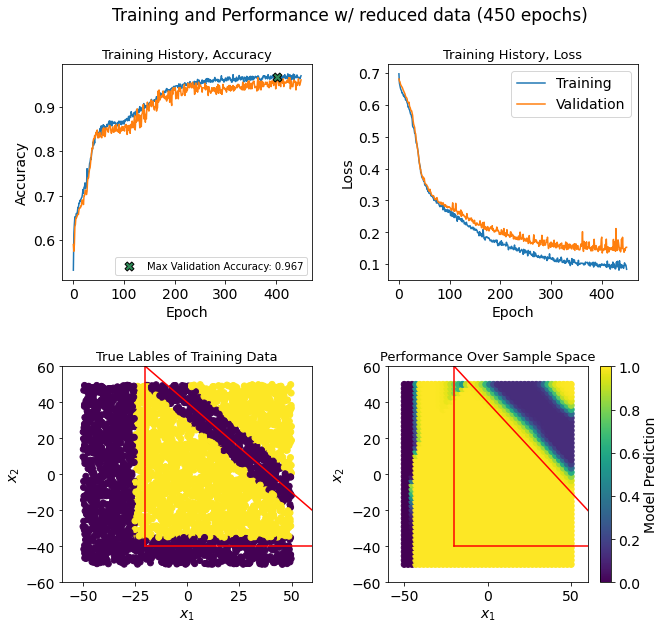

In [53]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_red = np.max(fit_red.history['val_accuracy'])
max_val_epoch_red = np.argmax(fit_red.history['val_accuracy'])
print('The best validation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_red, max_val_epoch_red))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ reduced data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_red, 3))
ax.scatter(max_val_epoch_red, max_val_acc_red, color='seagreen', edgecolors="black", marker='X', s=80, label=mystring, zorder = 10)
ax.plot(fit_red.history['accuracy'])
ax.plot(fit_red.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_red.history['loss'], label="Training")
ax.plot(fit_red.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20), (-40,60), c="r")
    ax.plot((-20,80), (-40,-40), c="r")
    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

We have a high number of false positives when trained on a reduced dataset. We think tha now we have imbalanced dataset: if  reduced dataset is imbalanced, meaning that it has significantly more samples from one class than the other, then the model may learn to prioritize the majority class and produce more false positives for the minority class. 

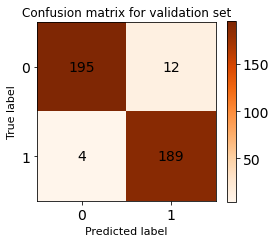

In [54]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_red)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_red, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Increased Data <a class="anchor" id="increased"></a>


We now increase the number of samples in the original dataset by generating data with the nonlinear function `f(x, c=1)` below. The new number of samples is `N=8000`.

The reason for doing this is to see if the accuracy increases by much compared to that for the model trained on the original dataset. If it turns out to be so, it means that the original dataset was too small to get good results.

In [55]:
# Nonlinear function of a 2d array x
def f(x, c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s, TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

With increased dataset we got it leads to  Increased computational complexit- Increased data can significantly increase the size of a dataset, which can require more computational resources to train a model. This can result in longer training times, higher memory usage, and slower model inference times. So computationale time was moticable longer

In [56]:
# Parameters for the new data

# Number of data
N=8000

# Size of each sample
L=2

# Box size
B=100

#!mkdir DATA

2 5 1
./DATA/data_new-for-DNN-1.dat
./DATA/labels_new-for-DNN-1.dat


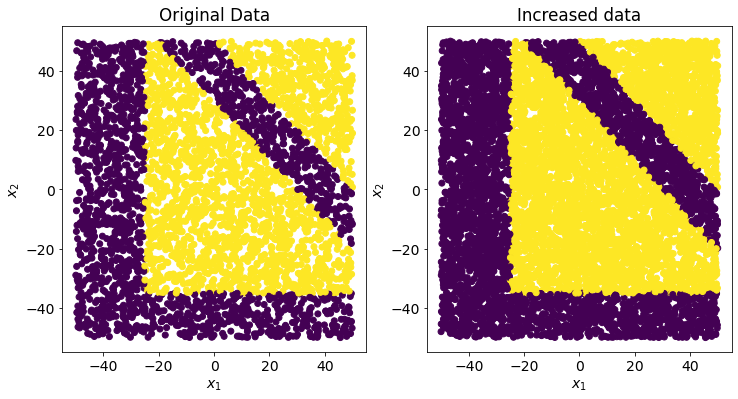

In [57]:
from matplotlib import cm

TYPE=1

# Random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10), np.random.randint(0,10), np.random.randint(0,10))

x_increased, y_increased = (np.random.random((N,2))-0.5)*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y_increased[i] = f(x_increased[i], TYPE)
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x_increased[:,0], x_increased[:,1], c=y_increased)        
axs[1].set_title('Increased data')

axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')

plt.show

fn = filename("data_new", TYPE)
np.savetxt(fn, x_increased)
print(fn)
fn = filename("labels_new", TYPE)
np.savetxt(fn, y_increased, fmt="%d")
print(fn)

In [58]:
x = np.loadtxt('./DATA/data_new-for-DNN-1.dat')
y = np.loadtxt('./DATA/labels_new-for-DNN-1.dat')

In [59]:
Per_train = 0.8
N = len(x)
L = len(x[0])
N_train = int(Per_train*N)
print("Number of samples in the increased dataset:", N)
print("Number of samples in the train increased dataset:", N_train)

Number of samples in the increased dataset: 8000
Number of samples in the train increased dataset: 6400


In [60]:
# Defining the trainig and validations sets
(x_train_incr, y_train_incr) = (x[0:N_train], y[0:N_train])
(x_valid_incr, y_valid_incr) = (x[N_train:], y[N_train:])
print("Train:", len(x_train_incr), "\t Validation:", len(x_valid_incr))

Train: 6400 	 Validation: 1600


In [61]:
# Rescaling the dataset
def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train_incr = Rescaling(x_train_incr)
x_valid_incr = Rescaling(x_valid_incr)

print("Number of samples in the increased set:", len(x_train_incr))

Number of samples in the increased set: 6400


In [62]:
# Creating and training our NN model w/ the increased dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with increased data
fit_incr = best_model.fit(x_train_incr, y_train_incr, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_incr, y_valid_incr), verbose=False)

The best validation accuracy is 0.888.
The accuracy difference between original and increased datasets is 0.006.


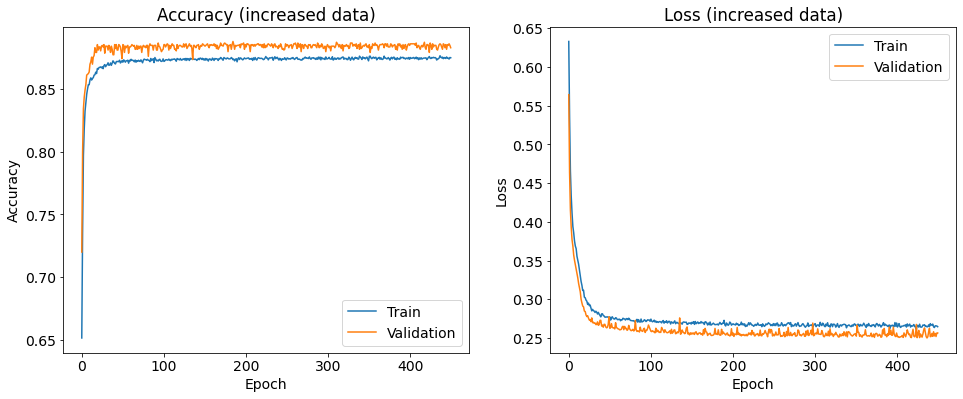

In [63]:
# Printing the max validation accurancy for the increased dataset and
# the difference w/ the one of original dataset
max_val_acc_incr = np.max(fit_incr.history['val_accuracy'])
print('The best validation accuracy is %.3f.' %(max_val_acc_incr))
print('The accuracy difference between original and increased datasets is %.3f.' %((max_val_acc-max_val_acc_incr)))

# Creating the plots
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# accuracy in training and validation
ax1.plot(fit_incr.history['accuracy'])
ax1.plot(fit_incr.history['val_accuracy'])
ax1.set_title('Accuracy (increased data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# loss in training and validation
ax2.plot(fit_incr.history['loss'])
ax2.plot(fit_incr.history['val_loss'])
ax2.set_title('Loss (increased data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The max accuracy reached by the model w/ the increased dataset is slightly lower (9.8%) than the one achieved w/ the original dataset (88.7% vs 94.1%). 
The difference between the two values is little, thus we can infer that the original dataset contains the correct number of samples to precisely train our NN model.

The best validation accuracy, 0.888, was achieved on the 184th epoch.


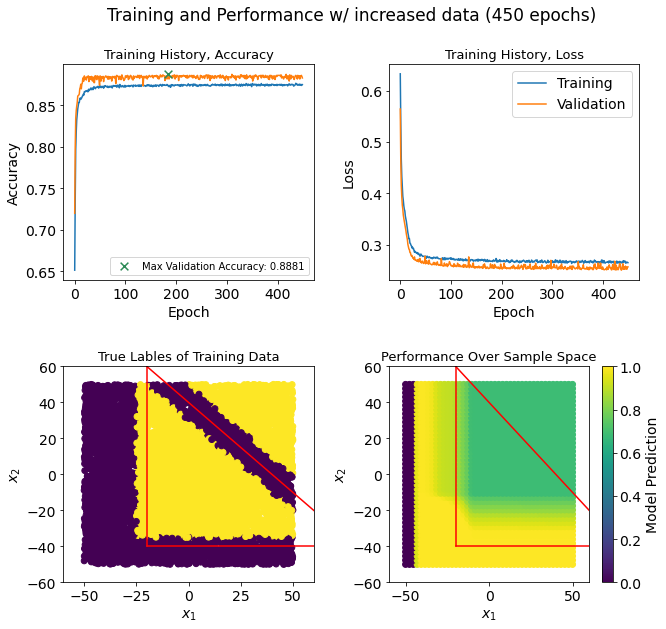

In [66]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(x1[j], x2[i])
        k = k+1
        
# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_incr = np.max(fit_incr.history['val_accuracy'])
max_val_epoch_incr = np.argmax(fit_incr.history['val_accuracy'])
print('The best validation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_incr, max_val_epoch_incr))

#plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle('Training and Performance w/ increased data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax=AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_incr, 4))
ax.scatter(max_val_epoch_incr, max_val_acc_incr, color='seagreen', edgecolors="black", marker='x', s=60, label=mystring, zorder = 10)
ax.plot(fit_incr.history['accuracy'])
ax.plot(fit_incr.history['val_accuracy'])
ax.legend(fontsize=10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_incr.history['loss'], label="Training")
ax.plot(fit_incr.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20, -20), (-40, 60), c="r")
    ax.plot((-20, 80), (-40, -40), c="r")
    ax.plot((-20, 80), (60, -40), c="r")
    
# True Lables of Training Data
ax = AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

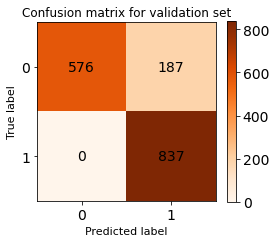

In [67]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_incr)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_incr, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Augmented Data <a class="anchor" id="aug"></a>

The code "augments" the data by generating synthetic samples that are slightly shifted from the original ones. This can help increasing the diversity and size of the dataset and prevent overfitting of the DNN model.

It loops over each sample in x=($x_1$, $x_2$) (assuming they have the same length N) and generates N_augment copies of each sample by adding a random shift drawn from a normal distribution with mean 0 and standard deviation 0.05. The shift is applied to just the training sample `x_train`. 
The "noise" is not added to the validation sample `x_valid` . After every epoch, the model checks, on the validation set, if the training was good.In machine learning, it is widely accepted that data augmentation should be performed on the training set and not the validation set. This practice is aimed at preventing data leakage and ensuring that the validation set remains representative of the true distribution of the data.

Data leakage is a common problem in machine learning, where information from the validation set can unintentionally leak into the training process, leading to overly optimistic estimates of the model's performance. Augmenting the validation set can potentially introduce data leakage, as the same data transformations applied to the training set may also be applied to the validation set.

To avoid data leakage, it is crucial to keep the validation set separate from the training set and not modify it in any way during the training process. This guarantees that the validation set remains a true representation of the real-world data that the model will encounter, allowing us to accurately evaluate the model's performance on new, unseen data. By augmenting the training set instead, we can provide the model with more diverse examples to learn from, enabling it to better generalize to new, unseen data while reducing the risk of overfitting.



 So we want to keep the original validation set in order to allow the model to understand if it's learning in the right way.

One possible reason for doing this is to improve the generalization ability of the DNN model by exposing it to more variations of the data.

In [81]:
# Load the original dataset
x_aug = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y_aug = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

In [82]:
Per_train = 0.8
N = len(x_aug)
L = len(x_aug[0])
N_train = int(Per_train*N)
print("Number of samples in the augmented dataset:", N)
print("Number of samples in the train augmented dataset:", N_train)

Number of samples in the augmented dataset: 4000
Number of samples in the train augmented dataset: 3200


In [83]:
# Defining the trainig and validations sets
(x_train_aug1, y_train_aug1) = (x_aug[0:N_train], y_aug[0:N_train])
(x_valid_aug1, y_valid_aug1) = (x_aug[N_train:], y_aug[N_train:])

print("Train:", len(x_train_aug1), "\t Validation:", len(x_valid_aug1))

Train: 3200 	 Validation: 800


In [84]:
# Generating Gaussian noise
x_s = np.random.normal(loc=0.0, scale=0.05, size=x_train_aug1.shape[:2])
#y_s = np.random.normal(loc=0.0, scale=0.05, size=y_train_aug1.shape[:1])

# "Augmenting" the training samples by addig Gaussian noise
x_train_aug2 = (x_train_aug1 + x_s ) 
x_train_aug_1 = np.concatenate((x_train_aug1, x_train_aug2), axis=0) 

y_train_aug = np.concatenate((y_train_aug1, y_train_aug1), axis=0) 

print("Number of samples in original ", len(x_aug))
print("Number of train samples in augmented set:", len(x_train_aug_1))
print("n° of train labels in augmented set:", len(y_train_aug))
print("n° validation samples in original set:", len(x_valid_aug1))
print("n° validation labels in augmented set:", len(y_valid_aug1))

Number of samples in original  4000
Number of train samples in augmented set: 6400
n° of train labels in augmented set: 6400
n° validation samples in original set: 800
n° validation labels in augmented set: 800


In [85]:
def Rescaling(x):
    X = (x-x.mean())/x.std()
    return X

x_train_aug = Rescaling(x_train_aug_1)
x_valid_aug = Rescaling(x_valid_aug1)

print("Number of samples in train augmented set:", len(x_train_aug))

Number of samples in train augmented set: 6400


7200 7200


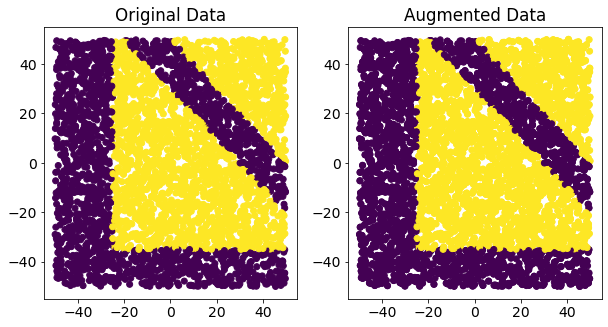

In [86]:
# Creating the total augmented dataset
x_tot_aug = np.concatenate((x_train_aug_1, x_valid_aug1), axis=0)
y_tot_aug = np.concatenate((y_train_aug, y_valid_aug1), axis=0)

print(len(x_tot_aug), len(y_tot_aug))

# Plot the original data and the augmented data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(x_aug[:, 0], x_aug[:, 1], c=y_aug)
axs[0].set_title('Original Data')

axs[1].scatter(x_tot_aug[:, 0], x_tot_aug[:, 1] , c=y_tot_aug)
axs[1].set_title('Augmented Data')
plt.show()

The two plots look similar beacause of the method we used to augment the dataset: we took the original data, we added the noise and then we merged this new dataset with the original one. 
Overall the augmented dataset have the double of samples (in the training set), but all the values are close to the original ones, because half of the new dataset is made from the original data and the other half is made of samples whose values are slightly different from the originals, due to the Gaussian noise (always in the training set). Thus, in the "Augmented Data" plot the samples slightly overlap eachother and the size of the dots and the scale of the graph make it difficult to distinguish them.

In [87]:
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

#Fitting again with more data
fit_aug = best_model.fit(x_train_aug, y_train_aug, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_aug, y_valid_aug1), verbose=False)

The best validation accuracy is 0.877.
The accuracy difference between original and augmented datasets is 0.016.


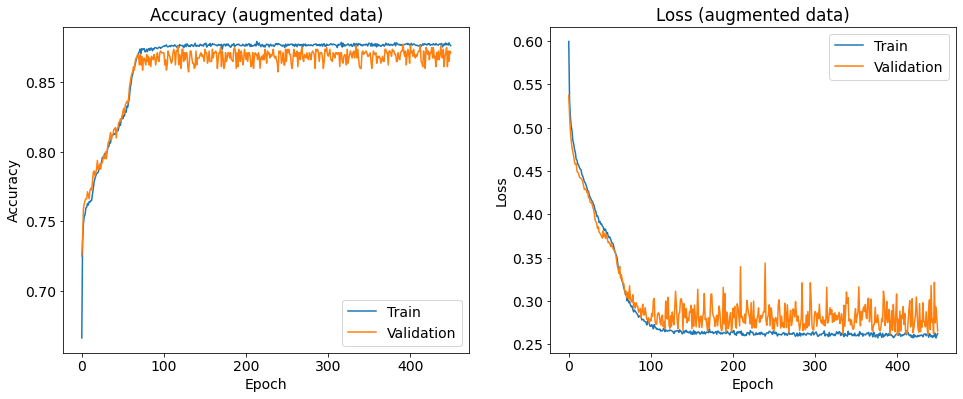

In [88]:
# Printing the max validation accurancy for the augmented dataset and
# the difference w/ the one of original dataset
max_val_acc_aug = np.max(fit_aug.history['val_accuracy'])
print('The best validation accuracy is %.3f.' %(max_val_acc_aug))
print('The accuracy difference between original and augmented datasets is %.3f.' %((max_val_acc-max_val_acc_aug)))

# Creating the plots
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_aug.history['accuracy'])
ax1.plot(fit_aug.history['val_accuracy'])
ax1.set_title('Accuracy (augmented data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_aug.history['loss'])
ax2.plot(fit_aug.history['val_loss'])
ax2.set_title('Loss (augmented data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

Here we can see that validation accuracy are slighter better than trainig, one of the reason because we did augmentation for trainig set.When using an augmented dataset in training, it is possible to achieve better validation accuracy than with just the original training data. This is because data augmentation can provide additional training examples that can help the model learn to generalize better to new, unseen data.

The best validation accuracy, 0.877, was achieved on the 391th epoch.


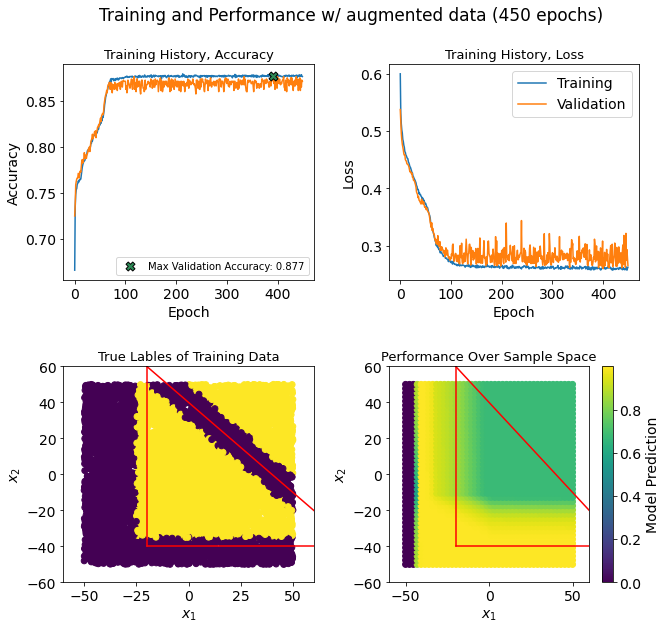

In [90]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_aug = np.max(fit_aug.history['val_accuracy'])
max_val_epoch_aug = np.argmax(fit_aug.history['val_accuracy'])
print('The best validation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_aug, max_val_epoch_aug))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ augmented data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_aug, 3))
ax.scatter(max_val_epoch_aug, max_val_acc_aug, color='seagreen', edgecolors="black", marker='X', s=80, label=mystring, zorder = 10)
ax.plot(fit_aug.history['accuracy'])
ax.plot(fit_aug.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_aug.history['loss'], label="Training")
ax.plot(fit_aug.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20), (-40,60), c="r")
    ax.plot((-20,80), (-40,-40), c="r")
    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

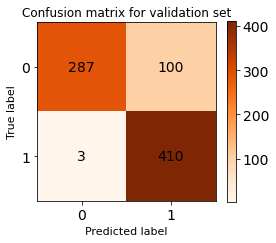

In [91]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_aug)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_aug1, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Task 3 (butterfly) <a class="anchor" id="butterfly"></a>

We generated data from a nonlinear function returning a butterfly shape.

In [92]:
x_shape = np.loadtxt('./DATA/data-for-butterfly-DNN-1.dat')
y_shape = np.loadtxt('./DATA/labels-for-butterfly-DNN-1.dat')

In our experiment, we started by training our machine learning model on a dataset of rectangles. Once we had achieved a satisfactory level of performance on this simple dataset, we wanted to test the model's ability to generalize to slightly more complex shapes.

To achieve this, we introduced a new dataset containing two additional shapes - a butterfly-shaped figure and a simple circle resembling the planet Jupiter. By including these two shapes in our dataset, we were able to compare the model's performance on different non-linear functions and assess its ability to generalize to more complex patterns.

The butterfly shape presented a slightly more challenging task for the model due to its non-linear and irregular features. In contrast, the circle shape had a much simpler and more regular pattern, which made it easier for the model to learn and generalize from the data.

Through comparing the model's performance on these different shapes, we were able to gain valuable insights into its ability to learn and generalize to non-linear functions. This information can be useful for future applications of machine learning, particularly those involving complex data and pattern recognition tasks. Overall, our experiment highlights the importance of testing and evaluating machine learning models on a diverse range of datasets to ensure their robustness and reliability in real-world applications.

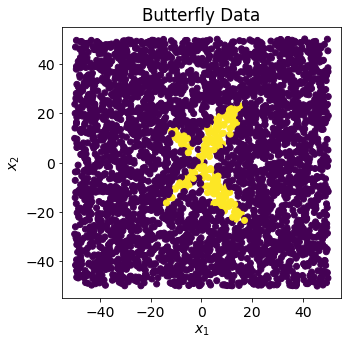

In [93]:
# Plot the butterfly data
plt.figure(figsize=(5,5))

plt.scatter(x_shape[:, 0], x_shape[:, 1], c=y_shape)
plt.title('Butterfly Data')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

In [94]:
Per_train = 0.8
N = len(x_shape)
L = len(x_shape[0])
N_train = int(Per_train*N)
print("Number of samples in the butterfly dataset:", N)
print("Number of samples in the train butterfly dataset:", N_train)

Number of samples in the butterfly dataset: 4000
Number of samples in the train butterfly dataset: 3200


In [95]:
# Defining the trainig and validations sets
(x_train_shape, y_train_shape) = (x_shape[0:N_train], y_shape[0:N_train])
(x_valid_shape, y_valid_shape) = (x_shape[N_train:], y_shape[N_train:])
print("Train:", len(x_train_shape), "\t Validation:", len(x_valid_shape))

Train: 3200 	 Validation: 800


In [96]:
# Creating and training our NN model w/ the butterfly dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with butterfly data
fit_shape = best_model.fit(x_train_shape, y_train_shape, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_shape, y_valid_shape), verbose=False)

The best validation accuracy is 0.959.
The accuracy difference between original and butterfly datasets is -0.065.


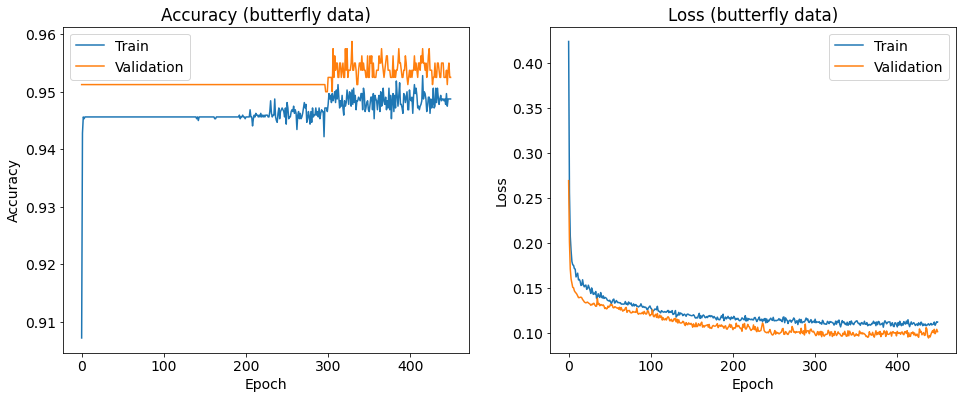

In [97]:
# Printing the max validation accurancy for the butterfly dataset and
# the difference w/ the one of original dataset
max_val_acc_shape = np.max(fit_shape.history['val_accuracy'])
print('The best validation accuracy is %.3f.' %(max_val_acc_shape))
print('The accuracy difference between original and butterfly datasets is %.3f.' %((max_val_acc-max_val_acc_shape)))

# Creating the plots
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_shape.history['accuracy'])
ax1.plot(fit_shape.history['val_accuracy'])
ax1.set_title('Accuracy (butterfly data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_shape.history['loss'])
ax2.plot(fit_shape.history['val_loss'])
ax2.set_title('Loss (butterfly data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

Our model achieved a pretty high accuracy value on the test data. This is a good result considering that we used a linear model to fit a nonlinear function. Moreover, our model was robust to noise and data augmentation, as it performed equally well on another dataset that had different shifts and scales. This shows that our model can well generalize unseen data and handle some degree of variation and uncertainty.

One interesting observation from our experiment was that the validation and training accuracy of our machine learning model were almost identical. This means that the model was able to generalize well to new, unseen data and did not suffer from overfitting to the training set.

The best validation accuracy, 0.959, was achieved on the 329th epoch.


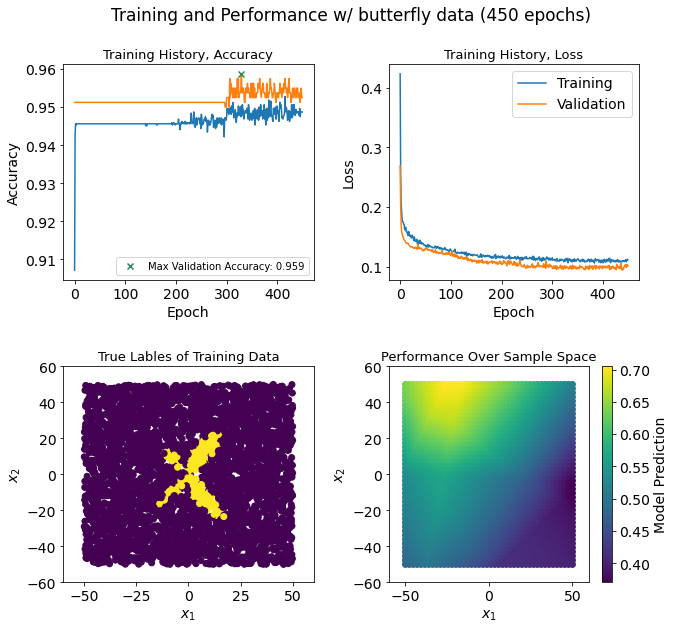

In [98]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_shape = np.max(fit_shape.history['val_accuracy'])
max_val_epoch_shape = np.argmax(fit_shape.history['val_accuracy'])
print('The best validation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_shape, max_val_epoch_shape))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ butterfly data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_shape, 3))
ax.scatter(max_val_epoch_shape, max_val_acc_shape, color='seagreen', marker='x', label=mystring, zorder = 10)
ax.plot(fit_shape.history['accuracy'])
ax.plot(fit_shape.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_shape.history['loss'], label="Training")
ax.plot(fit_shape.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

#def boundaries():    
#    ax.plot((-20,-20), (-40,60), c="r")
#    ax.plot((-20,80), (-40,-40), c="r")
#    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x_shape[:,0], x_shape[:,1], c=y_shape)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

#boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

#boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

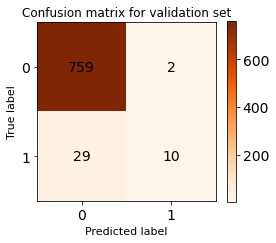

In [57]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_shape)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_shape, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()

# Task 3 (Jupiter) <a class="anchor" id="jupiter"></a>

We generated data from a nonlinear function returning a butterfly shape.

In [99]:
x_jup = np.loadtxt('./DATA/data_new-for-jup-DNN-1.dat')
y_jup = np.loadtxt('./DATA/labels_new-for-jup-DNN-1.dat')

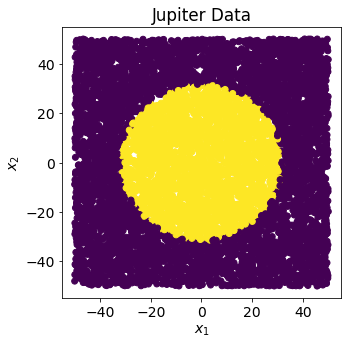

In [100]:
# Plot the jupiter data
plt.figure(figsize=(5,5))

plt.scatter(x_jup[:, 0], x_jup[:, 1], c=y_jup)
plt.title('Jupiter Data')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()

In [101]:
Per_train = 0.8
N = len(x_jup)
L = len(x_jup[0])
N_train = int(Per_train*N)
print("Number of samples in the jupiter dataset:", N)
print("Number of samples in the train jupiter dataset:", N_train)

Number of samples in the jupiter dataset: 8000
Number of samples in the train jupiter dataset: 6400


In [102]:
# Defining the trainig and validations sets
(x_train_jup, y_train_jup) = (x_jup[0:N_train], y_jup[0:N_train])
(x_valid_jup, y_valid_jup) = (x_jup[N_train:], y_jup[N_train:])
print("Train:", len(x_train_jup), "\t Validation:", len(x_valid_jup))

Train: 6400 	 Validation: 1600


In [103]:
# Creating and training our NN model w/ the jupiter dataset
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size

# Fitting with butterfly data
fit_jup = best_model.fit(x_train_jup, y_train_jup, epochs=epochs, batch_size=batch_size, validation_data=(x_valid_jup, y_valid_jup), verbose=False)

The best validation accuracy is 0.995.
The accuracy difference between original and jupiter datasets is -0.101.


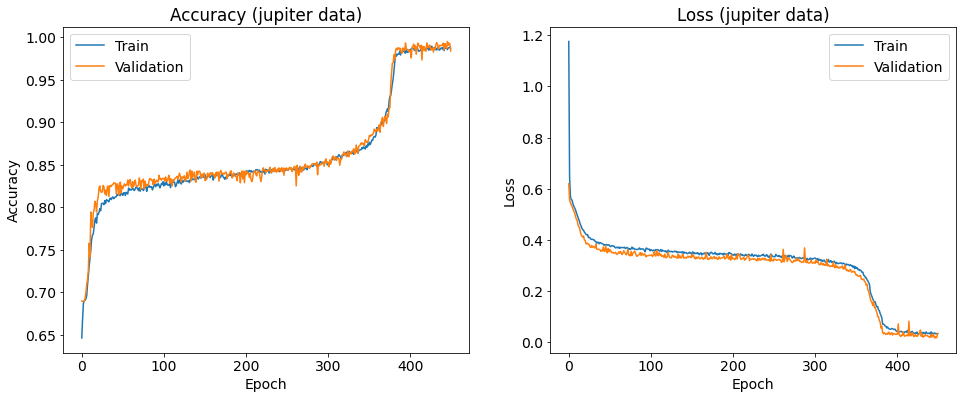

In [104]:
# Printing the max validation accurancy for the jupiter dataset and
# the difference w/ the one of original dataset
max_val_acc_jup = np.max(fit_jup.history['val_accuracy'])
print('The best validation accuracy is %.3f.' %(max_val_acc_jup))
print('The accuracy difference between original and jupiter datasets is %.3f.' %((max_val_acc-max_val_acc_jup)))

# Creating the plots
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit_jup.history['accuracy'])
ax1.plot(fit_jup.history['val_accuracy'])
ax1.set_title('Accuracy (jupiter data)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit_jup.history['loss'])
ax2.plot(fit_jup.history['val_loss'])
ax2.set_title('Loss (jupiter data)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

As in the previous case, the butterfly dataset, the model achieved a pretty high accuracy value on the test data. In this case the accuracy is almost 1 (0.998). This is a good result considering that we used a linear model to fit a nonlinear function. This shows, another time, that our model can well generalize unseen data and handle some degree of variation and uncertainty.

The best validation accuracy, 0.995, was achieved on the 445th epoch.


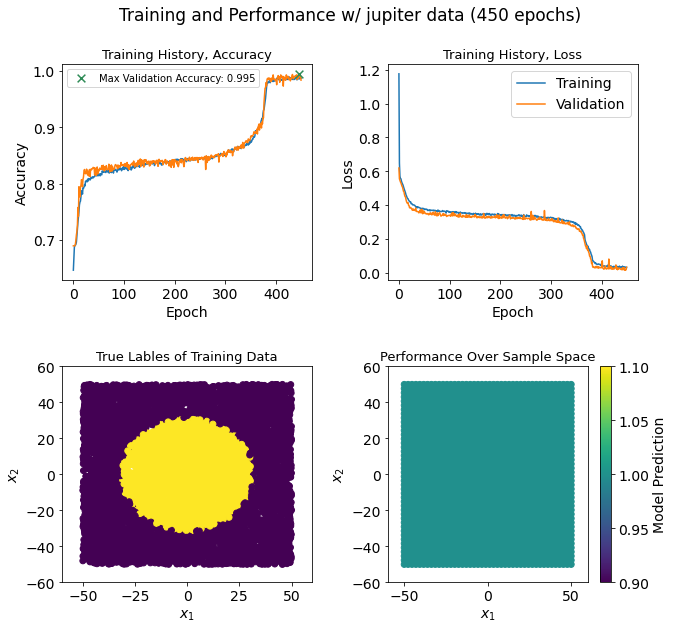

In [108]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50, 50, LG)
x2 = np.linspace(-50, 50, LG)
grid = np.zeros((LG*LG, 2))
k = 0
for i in range(LG):
    for j in range(LG):
        grid[k,:] = (x1[j], x2[i])
        k = k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_jup = np.max(fit_jup.history['val_accuracy'])
max_val_epoch_jup = np.argmax(fit_jup.history['val_accuracy'])
print('The best validation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc_jup, max_val_epoch_jup))

# Plot perfomance vs epochs
fig, AX = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Training and Performance w/ jupiter data (450 epochs)', y=1, fontsize=17)

# Training History, Accuracy
ax = AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_jup, 3))
ax.scatter(max_val_epoch_jup, max_val_acc_jup, color='seagreen', edgecolors="black", marker='x', s=60, label=mystring, zorder = 10)
ax.plot(fit_jup.history['accuracy'])
ax.plot(fit_jup.history['val_accuracy'])
ax.legend(fontsize = 10)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

# Training History, Loss
ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_jup.history['loss'], label="Training")
ax.plot(fit_jup.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

#def boundaries():    
#    ax.plot((-20,-20), (-40,60), c="r")
#    ax.plot((-20,80), (-40,-40), c="r")
#    ax.plot((-20,80), (60,-40), c="r")

# True Lables of Training Data
ax=AX[1][0]
ax.scatter(x_jup[:,0], x_jup[:,1], c=y_jup)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

#boundaries()

# Performance Over Sample Space
ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

#boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

We observed that models perform better when the input data has simpler shapes. This is because simpler shapes contain fewer variations in features and patterns, making it easier for the model to learn and generalize from the data.

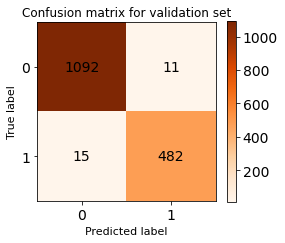

In [109]:
# Predicting the labels for the validation set
y_pred = best_model.predict(x_valid_jup)
y_pred = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_valid_jup, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
plt.title('Confusion matrix for validation set', fontsize=12)
plt.xlabel('Predicted label', fontsize=11)
plt.ylabel('True label', fontsize=11)
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.colorbar(shrink=0.83)
plt.xticks([0,1], ['0', '1'])
plt.yticks([0,1], ['0', '1'])

# Adding the number of predictions to each cell
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')

plt.show()